In [2]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf

In [3]:
!pip install kaggle

!kaggle datasets download -d sshikamaru/udacity-self-driving-car-dataset


Dataset URL: https://www.kaggle.com/datasets/sshikamaru/udacity-self-driving-car-dataset
License(s): other
udacity-self-driving-car-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
dataset_path = '/Users/Pauline/autonomous-vehicle-classifier/udacity-self-driving-car-dataset/data/export'
annotatinos_path = '/Users/Pauline/autonomous-vehicle-classifier/udacity-self-driving-car-dataset/data/export/_annotations.csv'

In [5]:
annotations_path = os.path.join(dataset_path, '_annotations.csv')
annotations = pd.read_csv(annotations_path)
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('jpg')]

annotations.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291,247,370,331
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270,235,293,321
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0,266,13,327
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25,258,106,304
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111,259,135,289


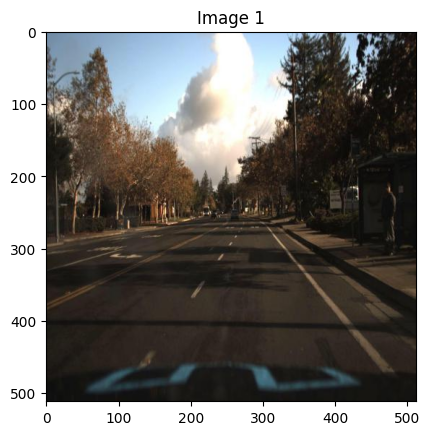

<bound method NDFrame.head of                                                  filename  width  height  \
0       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
1       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
2       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
3       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
4       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
...                                                   ...    ...     ...   
194534  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194535  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194536  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194537  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194538  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   

             class  xmin  ymin  xmax  ymax  
0           

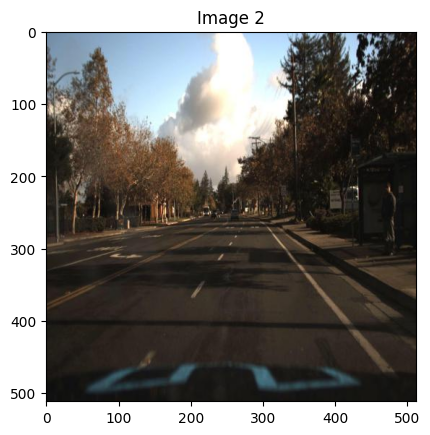

<bound method NDFrame.head of                                                  filename  width  height  \
0       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
1       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
2       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
3       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
4       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
...                                                   ...    ...     ...   
194534  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194535  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194536  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194537  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194538  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   

             class  xmin  ymin  xmax  ymax  
0           

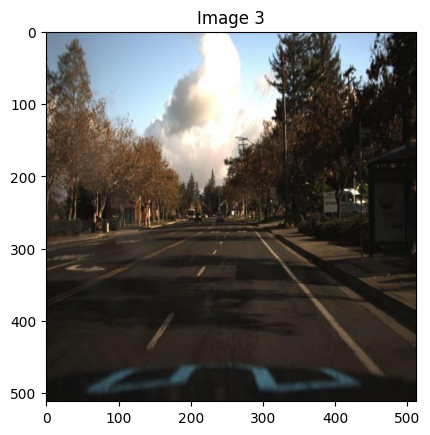

<bound method NDFrame.head of                                                  filename  width  height  \
0       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
1       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
2       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
3       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
4       1478900859981702684_jpg.rf.6830635c7d919747563...    512     512   
...                                                   ...    ...     ...   
194534  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194535  1478732062311919775_jpg.rf.Nu2jAeWJSd9IYifCzdo...    512     512   
194536  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194537  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   
194538  1478896613013843428_jpg.rf.NoYaQUi79nwjrvXUYmF...    512     512   

             class  xmin  ymin  xmax  ymax  
0           

In [6]:
for i in range (3):
    img = Image.open(image_files[i])
    plt.figure()
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.show()
    print(annotations.head)

In [7]:
def iou(boxA, boxB):
    xA = max([boxA[0], boxB[0]])
    yA = max([boxA[1], boxB[1]])
    xB = min([boxA[2], boxB[2]])
    yB = min([boxA[3], boxB[3]])
    
    interArea = max(0, xB - xA+1) * max(0, yB - yA+1)
    
    #boxA = ground truth boxB = predicted
    boxAArea = (boxA[2] - boxA[0]+1) * (boxA[3] - boxA[1]+1)
    boxBArea = (boxB[2] - boxB[0]+1) * (boxB[3] - boxB[1]+1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

#remove 100% duplicate bounding boxes based on IoU threshold
def filter_duplicates(boxes, threshold=1):
    filtered_boxes = []
    for i, boxA in enumerate(boxes):
        to_add = True
        for boxB in filtered_boxes:
            if iou(boxA, boxB) == threshold:
                to_add = False
                break
        if to_add:
            filtered_boxes.append(boxA)
    return filtered_boxes

#example
bounding_boxes = [
    [100, 150, 200, 250],
    [100, 150, 200, 250],
    [110, 160, 210, 260],
]

filtered_boxes = filter_duplicates(bounding_boxes)
print(filtered_boxes)
iou_value = iou(bounding_boxes[0], bounding_boxes[1])
print(f"IoU between boxA and boxB: {iou_value}")

[[100, 150, 200, 250], [110, 160, 210, 260]]
IoU between boxA and boxB: 1.0


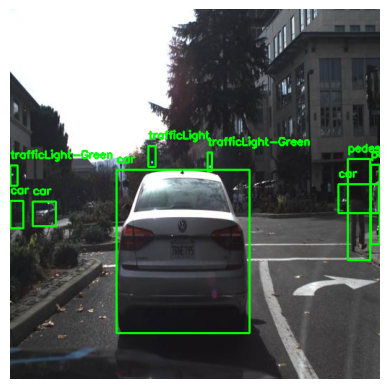

In [8]:
grouped_annotations = annotations.groupby("filename")

def draw_bounding_boxes(image_file, boxes, save_image=False, output_path=None):
    img_path = os.path.join(dataset_path, image_file)
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {img_path}")

    #draw each bounding box
    for _, row in boxes.iterrows():
        xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        label = row['class']

        #draw rectangle
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        # Put label text
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    if save_image:
        # Save image with bounding boxes
        if output_path:
            cv2.imwrite(output_path, image)  #save to given output path
        else:
            cv2.imwrite('output.jpg', image)  #default save

    #convert BGR to RGB for displaying
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

image_file = "1478899844799782363_jpg.rf.RAjpKgjL9L1sH6Yztakh.jpg"
boxes = grouped_annotations.get_group(image_file)  # Retrieve bounding boxes for the image
draw_bounding_boxes(image_file, boxes)


In [9]:
def normalize_bounding_boxes(bboxes, image_width, image_height):
    normalized_bboxes = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        
        #normalize bounding box coordinates
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        normalized_bboxes.append([x_center, y_center, width, height])
    
    return normalized_bboxes

image_width = 512
image_height = 512
bounding_boxes = [
    [100, 150, 200, 250], 
    [100, 150, 200, 250],
    [110, 160, 210, 260]
]

filtered_boxes = filter_duplicates(bounding_boxes)

normalized_boxes = normalize_bounding_boxes(filtered_boxes, image_width, image_height)

print(normalize_bounding_boxes(filtered_boxes,512,512))

[[0.29296875, 0.390625, 0.1953125, 0.1953125], [0.3125, 0.41015625, 0.1953125, 0.1953125]]


In [10]:
from tensorflow.keras import layers, models

def build_model(input_shape=(512, 512, 3), num_classes=11):
    model = models.Sequential()

    """
    Build CNN model for object detection that predicts both bounding boxes and class labels.
    
    Args:
    input_shape (tuple): The shape of input images (height, width, channels).
    num_classes (int): The number of object classes in the dataset.
    
    Returns:
    model (keras.Model): The compiled CNN model for object detection.
    """
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #flatten connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    
    #output layers:
    # 1. Bounding box: 4 values for [x_center, y_center, width, height]
    # 2. Class label: num_classes values, one per class (using softmax activation)
    model.add(layers.Dense(4, activation='sigmoid', name="bbox"))  
    model.add(layers.Dense(num_classes, activation='softmax', name="class"))  
    
    return model


In [11]:
# Prepare images and labels (no resizing)
def prepare_data(image_files, annotations):
    images = []
    bbox_labels = []
    class_labels = []

    for img_file in image_files:
        img_path = os.path.join(dataset_path, img_file)
        img = cv2.imread(img_path)  # Load image
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)

        # Retrieve bounding boxes and class labels
        boxes = annotations[annotations['filename'] == img_file]
        bboxes = []
        classes = []
        for _, row in boxes.iterrows():
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            class_label = row['class']

            bboxes.append([xmin, ymin, xmax, ymax])
            classes.append(class_label)
        
        # Normalize bounding boxes (no resizing, just normalize)
        normalized_bboxes = normalize_bounding_boxes(bboxes, 512, 512)
        bbox_labels.append(normalized_bboxes)
        class_labels.append(classes)

    return np.array(images), np.array(bbox_labels), np.array(class_labels)

# Example usage:
image_files = os.listdir(dataset_path)
annotations = pd.read_csv(annotations_path)  # Ensure this is loaded properly
images, bbox_labels, class_labels = prepare_data(image_files, annotations)



MemoryError: Unable to allocate 6.00 MiB for an array with shape (512, 512, 3) and data type float64

In [1]:
from tensorflow.keras.optimizers import Adam

# Build the model
model = build_model(input_shape=(512, 512, 3), num_classes=11)

# Compile the model with both bounding box and class label losses
model.compile(
    optimizer=Adam(),
    loss={'bbox': 'mean_squared_error', 'class': 'categorical_crossentropy'},
    metrics={'bbox': 'accuracy', 'class': 'accuracy'}
)

# Train the model
history = model.fit(
    X_train, 
    {'bbox': y_train_bbox, 'class': y_train_class},  # Separate outputs for bbox and class
    validation_data=(X_val, {'bbox': y_val_bbox, 'class': y_val_class}),
    epochs=10,
    batch_size=16
)

# Save the trained model
model.save('object_detection_model.h5')

KeyboardInterrupt: 